In [60]:
import importlib

import numpy as np
# import pandas as pd
# import scipy
# from scipy.stats import pearsonr

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
# import logomaker as lm

import tensorflow as tf

from Modules import utils, tf_utils, plot_utils
from Modules.tf_utils import mae_cor, correlate
import kMC_sequence_design as kmc

# import kMC_sequence_design_v2 as kmc_v2
from kMC_sequence_design import get_profile_chunk

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
# sns.set_theme()

In [2]:
importlib.reload(utils)
importlib.reload(tf_utils)
importlib.reload(plot_utils)
importlib.reload(kmc)
# importlib.reload(kmc_v2)

<module 'kMC_sequence_design' from '/home/alex/mnhn-internship_DeepCNN_ChIP-seq/kMC_sequence_design.py'>

Models

In [2]:
model_pol_name = "model_myco_pol_17"
# with tf.distribute.MirroredStrategy().scope():
model_pol = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_nuc_name = "model_myco_nuc_2"
model_nuc = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_coh_name = "model_myco_coh_14"
model_coh = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_rna_name = "weight_CNN_RNA_seq_2001_12_8_4_SRR7131299"  # order 'ATGC'
model_rna = tf.keras.models.load_model(
    f"/home/alex/shared_folder/JB_seqdes/{model_rna_name}.hdf5",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_nuc_etienne_name = "weights_with_rev_compl_rep2"
model_nuc_etienne = tf.keras.models.load_model(
    f"/home/alex/shared_folder/JB_seqdes/{model_nuc_etienne_name}.hdf5",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_rna.input_shape

2024-05-23 12:46:36.365257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-23 12:46:36.408417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-23 12:46:36.408579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-05-23 12:46:36.408627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-23 12:46:36.408742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

(None, 2001, 4, 1)

In [61]:
def energy_parser(file):
    energies = np.loadtxt(file)
    with open(file, "r") as f:
        n_seqs = 0
        for line in f:
            if n_seqs != 0 and line.startswith("#"):
                break
            if not line.startswith("#"):
                n_seqs += 1
    return np.transpose(energies.reshape(-1, n_seqs, energies.shape[1]), [1, 0, 2])

(1, 101, 5)
(1, 101, 5)
(1, 101, 5)
(1, 57, 5)
(2, 501, 5)
(2, 501, 5)
Building parent directories


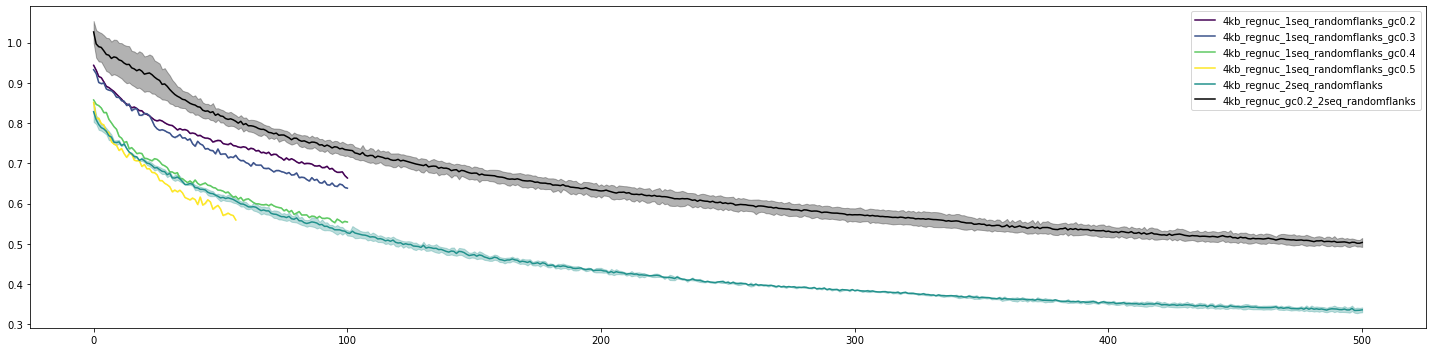

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor="w", layout="tight")
exp_ids = (
    [f"4kb_regnuc_1seq_randomflanks_gc{gc}" for gc in [0.2, 0.3, 0.4, 0.5]]
    + ["4kb_regnuc_2seq_randomflanks", "4kb_regnuc_gc0.2_2seq_randomflanks"]
)  # , "4kb_regnuc_1seq_randomflanks_W303_3mer"]#, "4kb_regnuc_2seq_randomflanks_nrl165_2"]
selected_colors = list(
    mpl.colormaps["viridis"](np.linspace(0, 1, len(exp_ids) - 1))[
        np.array([0, 1, 3, 4, 2])
    ]
) + ["k", "r"]  # colors
exp_labels = exp_ids
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, selected_colors):
    energies = energy_parser(
        f"/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt"
    )
    print(energies.shape)
    en_mean = energies[:, :, 0].mean(axis=0)
    en_std = energies[:, :, 0].std(axis=0)
    if len(en_mean) > 1:
        ax.fill_between(
            np.arange(len(en_mean)),
            en_mean - en_std,
            en_mean + en_std,
            color=color,
            alpha=0.3,
        )  # with std
    ax.plot(en_mean, label=exp_lab, color=color)
ax.legend()
filename = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_ids[0]}/energy.png"
)
fig.savefig(filename, bbox_inches="tight")

(1, 601, 5)
(1, 601, 5)
(1, 201, 5)
(1, 701, 5)
(1, 101, 5)
/home/alex/shared_folder/SCerevisiae/results/generated/20kb_lowpol_1seq_flanksInt2_longer/energy.png exists, changing filename to /home/alex/shared_folder/SCerevisiae/results/generated/20kb_lowpol_1seq_flanksInt2_longer/energy(2).png


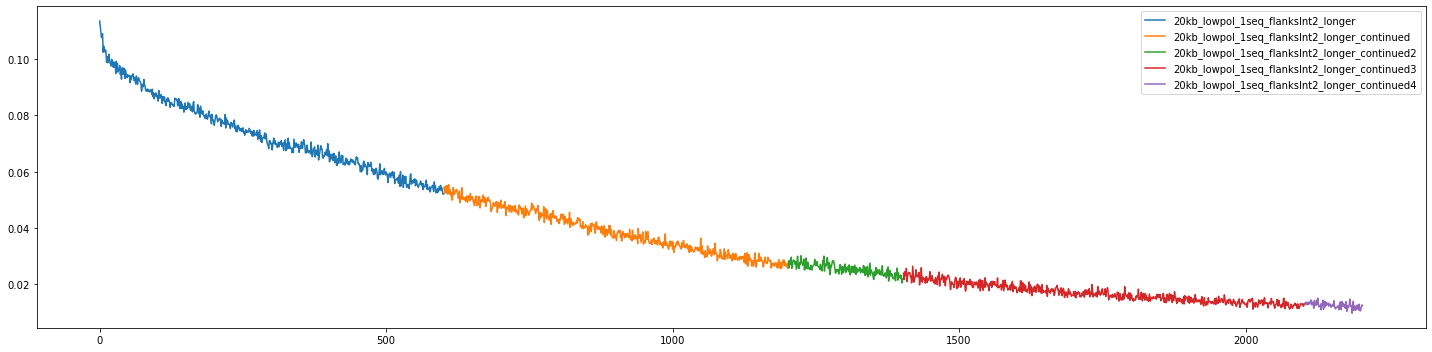

In [8]:
# continued experiments
fig, ax = plt.subplots(
    1, 1, figsize=(20, 5), facecolor="w", layout="tight"
)  # , sharey=True)
exp_ids = [
    f"20kb_lowpol_1seq_flanksInt2_longer{suff}"
    for suff in ["", "_continued", "_continued2", "_continued3", "_continued4"]
]
exp_labels = exp_ids
cur_step = 0
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    energies = energy_parser(
        f"/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt"
    )
    print(energies.shape)
    en_mean = energies[:, :, 0].mean(axis=0)
    en_std = energies[:, :, 0].std(axis=0)
    # ax.fill_between(np.arange(len(en_mean)), en_mean - en_std, en_mean + en_std, color=color, alpha=0.3)
    ax.plot(
        np.arange(cur_step, len(en_mean) + cur_step),
        en_mean,
        label=exp_lab,
        color=color,
    )
    cur_step += len(en_mean)
ax.legend()
filename = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_ids[0]}/energy.png"
)
fig.savefig(filename, bbox_inches="tight")

In [84]:
exp_name = "4kb_regnuc_2seq_randomflanks_nrl165_2"
seqs = [
    np.load(
        f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy"
    )
]
step = 0
while True:
    try:
        seqs.append(
            np.load(
                f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step{step}.npy"
            )
        )
        step += 1
    except FileNotFoundError:
        break
seqs = np.stack(seqs, axis=1)
print(seqs.shape)

(1, 101, 4000)


In [90]:
# multiple experiments comparision
exp_ids = [
    "4kb_regnuc_1seq_randomflanks_gc0.2",
    "4kb_regnuc_1seq_randomflanks_gc0.3",
    "4kb_regnuc_1seq_randomflanks_gc0.4",
    "4kb_regnuc_2seq_randomflanks",
    "4kb_regnuc_gc0.2_2seq_randomflanks",
]
seqs = []
for exp_name in exp_ids:
    seqs.append(
        np.array(
            [
                np.load(
                    f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy"
                ),
                np.load(
                    f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step99.npy"
                ),
            ]
        )
    )
seqs = np.concatenate(seqs, axis=1).transpose([1, 0, 2])
print(seqs.shape)

(7, 2, 4000)


In [12]:
# continued experiments
seqs = []
for exp_name in exp_ids:
    seqs.append(
        np.load(
            f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy"
        )
    )
seqs.append(
    np.load(
        f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step99.npy"
    )
)
seqs = np.stack(seqs, axis=1)
print(seqs.shape)

(1, 6, 20000)


In [91]:
with np.load(
    # "/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz"
    "/home/alex/shared_folder/SCerevisiae/data/S288c_siteManon_Int2_1kbflanks_ACGTidx.npz"
) as f:
    flank_left = f["left"]
    flank_right = f["right"]

In [92]:
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/target.npz"
) as f:
    target = f["forward"]
    target_rev = f["reverse"]

In [93]:
steps = np.arange(seqs.shape[1])  # np.array([0, -1])  #
to_predict = seqs[
    :, steps
]  # seqs[[0, -1], -1].flatten() # concatenation # seqs # .reshape(5, 2, -1)#
print(to_predict.shape)
flanks = (flank_left, flank_right)  # "self"  #
preds_pol, indices_pol = get_profile_chunk(
    to_predict, model_pol, 2048, 128, middle=True, return_index=True, flanks=flanks
)
preds_pol_rev, indices_pol_rev = get_profile_chunk(
    to_predict,
    model_pol,
    2048,
    128,
    reverse=True,
    middle=True,
    return_index=True,
    flanks=flanks,
)
preds_nuc, indices_nuc = get_profile_chunk(
    to_predict, model_nuc, 2001, return_index=True, flanks=flanks
)
preds_nuc_rev, indices_nuc_rev = get_profile_chunk(
    to_predict, model_nuc, 2001, reverse=True, return_index=True, flanks=flanks
)
preds_rna, indices_rna = get_profile_chunk(
    to_predict,
    model_rna,
    2001,
    one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order="ATGC", extradims=-1),
    return_index=True,
    flanks=flanks,
)
preds_rna_rev, indices_rna_rev = get_profile_chunk(
    to_predict,
    model_rna,
    2001,
    reverse=True,
    one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order="ATGC", extradims=-1),
    return_index=True,
    flanks=flanks,
)
# Merge forward and reverse
length = to_predict.shape[-1]
merge_pol = utils.mean_on_index(
    (indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length
)
merge_nuc = utils.mean_on_index(
    (indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length
)
# Save predictions on first and last sequences
filename = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/preds_start_end.npz"
)
np.savez(
    filename,
    preds_nuc=merge_nuc,
    preds_pol=merge_pol,
    preds_rna=preds_rna,
    preds_rna_rev=preds_rna_rev,
)

(7, 2, 4000)


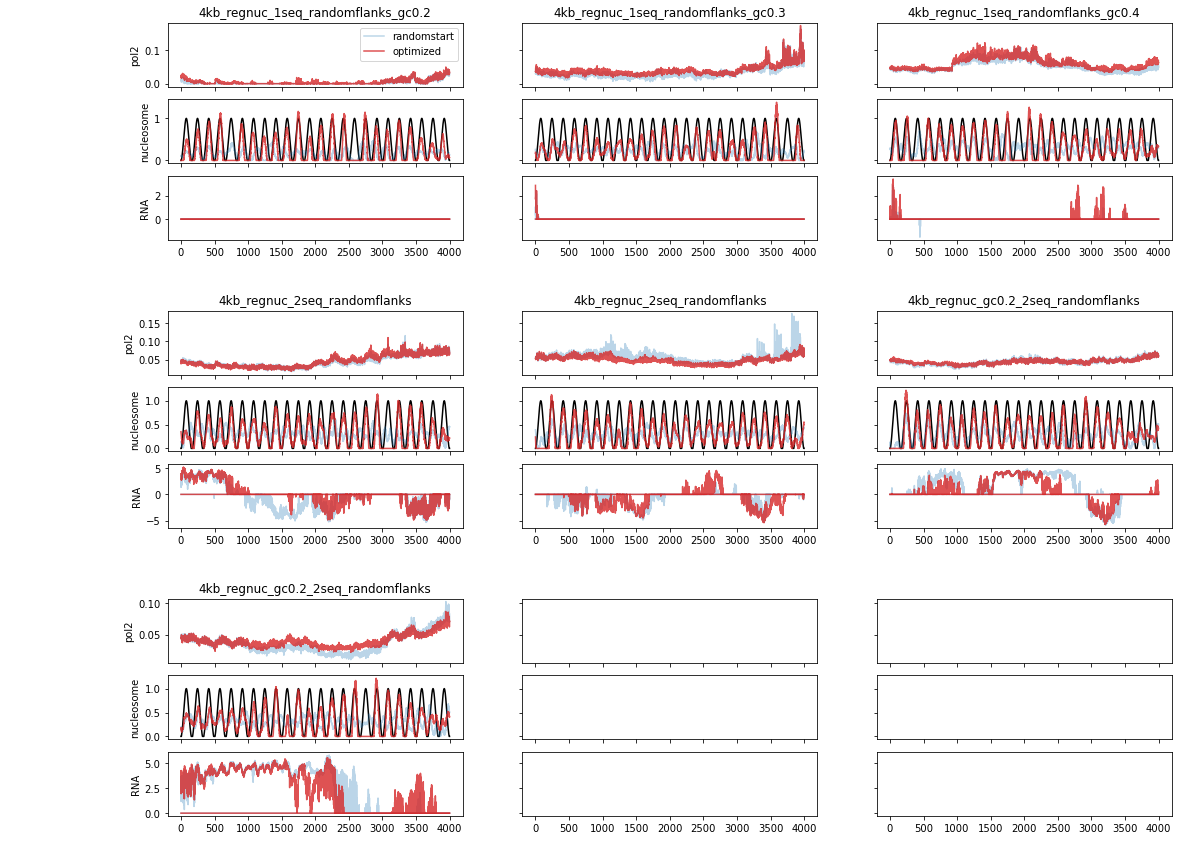

In [103]:
# many seq plot
seq_idxes = np.arange(7)
fig = plt.figure(figsize=(18, 12), facecolor="w")
subfigs = fig.subfigures(3, 1)
axes = [subfig.subplots(3, 3, sharex=True, sharey="row") for subfig in subfigs]
axes = np.array(axes)
targ_row = 1
# targ_ax.plot(-target_rev, color='k')
for j, seq_idx in enumerate(seq_idxes):
    exp_idx = seq_idx
    if exp_idx >= 4:
        exp_idx -= 1
    if exp_idx >= 5:
        exp_idx -= 1
    exp_name = exp_ids[exp_idx]
    with np.load(
        f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/target.npz"
    ) as f:
        target = f["forward"]
        target_rev = f["reverse"]
    subfig_row, ax_col = divmod(j, axes.shape[-1])
    axes[subfig_row, 0, ax_col].set_title(f"{exp_name}")
    axes[subfig_row, targ_row, ax_col].plot(target, color="k", label="target")
    if np.any(target_rev != target):
        axes[subfig_row, targ_row, ax_col].plot(
            -target_rev, color="k", label="target_rev"
        )
    for i, (color, lab, alpha) in enumerate(
        zip(colors[::3], ["randomstart", "optimized"], [0.3, 0.8])
    ):
        axes[subfig_row, 0, ax_col].plot(
            merge_pol[seq_idx, i, :], color=color, label=lab, alpha=alpha
        )
        axes[subfig_row, 1, ax_col].plot(
            merge_nuc[seq_idx, i, :], color=color, label=lab, alpha=alpha
        )
        axes[subfig_row, 2, ax_col].plot(
            indices_rna, preds_rna[seq_idx, i, :], color=color, label=lab, alpha=alpha
        )
        axes[subfig_row, 2, ax_col].plot(
            indices_rna_rev, -preds_rna_rev[seq_idx, i, :], color=color, alpha=alpha
        )
for ax, ylab in zip(axes[:, :, 0].flatten(), ["pol2", "nucleosome", "RNA"] * 3):
    ax.set_ylabel(ylab)
axes[0, 0, 0].legend()
# plot_utils.save_fig_and_values(
#     fig,
#     "/home/alex/shared_folder/SCerevisiae/generated/Tosend20240306/pol2_nus_rna_tandem_profiles",
#     format="svg",
# )
filename = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/all_profiles_start_end_some_gc.png"
)
fig.savefig(filename, bbox_inches="tight")

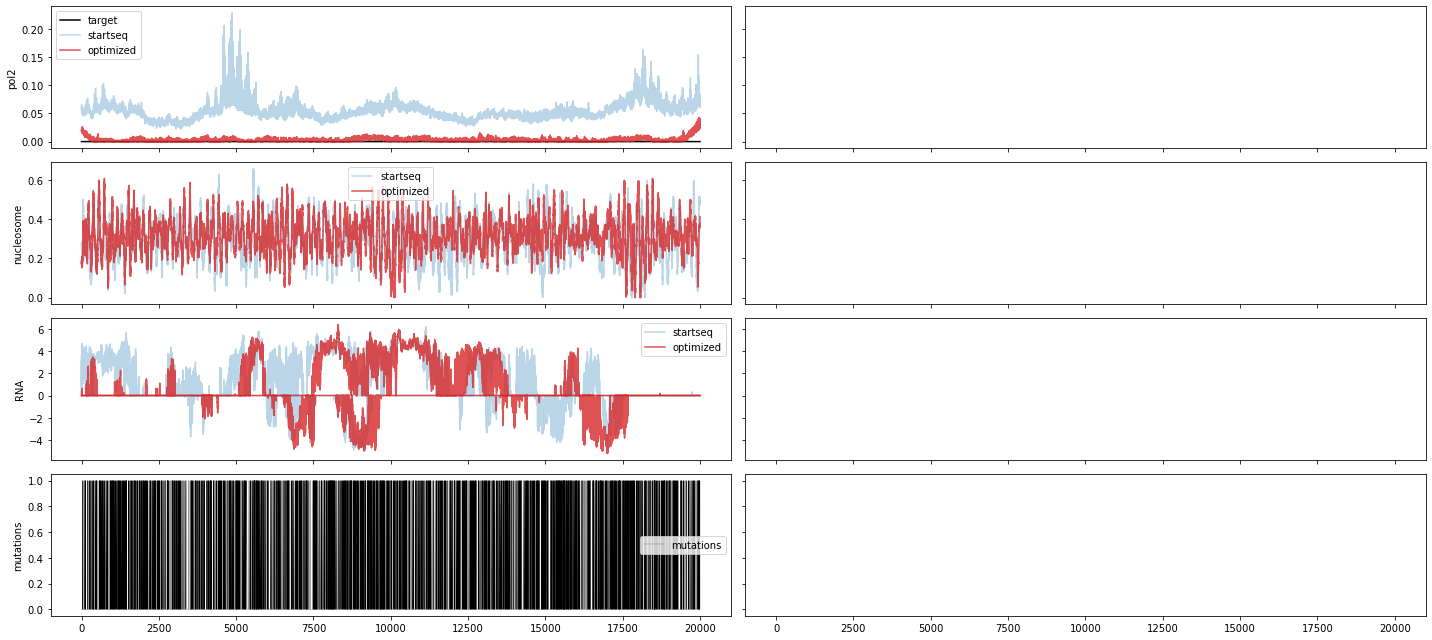

In [18]:
# double seq plot
start = 0
stop = 1
n_seqs = max(stop - start, 2)
length = to_predict.shape[-1]
targ_row = 0
fig, axes = plt.subplots(
    4, n_seqs, figsize=(20, 9), facecolor="w", layout="tight", sharex=True, sharey="row"
)
# targ_ax.plot(-target_rev, color='k')
for seq_idx in range(start, stop):
    ax_col = seq_idx - start
    axes[targ_row, ax_col].plot(target, color="k", label="target")
    if np.any(target_rev != target):
        axes[targ_row, ax_col].plot(-target_rev, color="k", label="target_rev")
    for i, (step, color, alpha, label) in enumerate(
        zip(steps, colors[::3], [0.3, 0.8], ["startseq", "optimized"])
    ):
        axes[0, ax_col].plot(
            merge_pol[seq_idx, i, :], color=color, label=label, alpha=alpha
        )
        axes[1, ax_col].plot(
            merge_nuc[seq_idx, i, :], color=color, label=label, alpha=alpha
        )
        axes[2, ax_col].plot(
            indices_rna, preds_rna[seq_idx, i, :], color=color, label=label, alpha=alpha
        )
        axes[2, ax_col].plot(
            indices_rna_rev, -preds_rna_rev[seq_idx, i, :], color=color, alpha=alpha
        )
        # break
    # axes[3, ax_col].bar(np.where(seqs[seq_idx, steps[0]] != seqs[seq_idx, steps[-1]])[0], height=1, width=1, color='k', label='mutations')
    axes[3, ax_col].plot(
        seqs[seq_idx, steps[0]] != seqs[seq_idx, steps[-1]],
        linewidth=0.2,
        color="k",
        label="mutations",
    )
for ax, ylab in zip(axes[:, 0], ["pol2", "nucleosome", "RNA", "mutations"]):
    ax.legend()
    ax.set_ylabel(ylab)
filename = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/profiles_start_end_with_mut.png"
)
fig.savefig(filename, bbox_inches="tight")

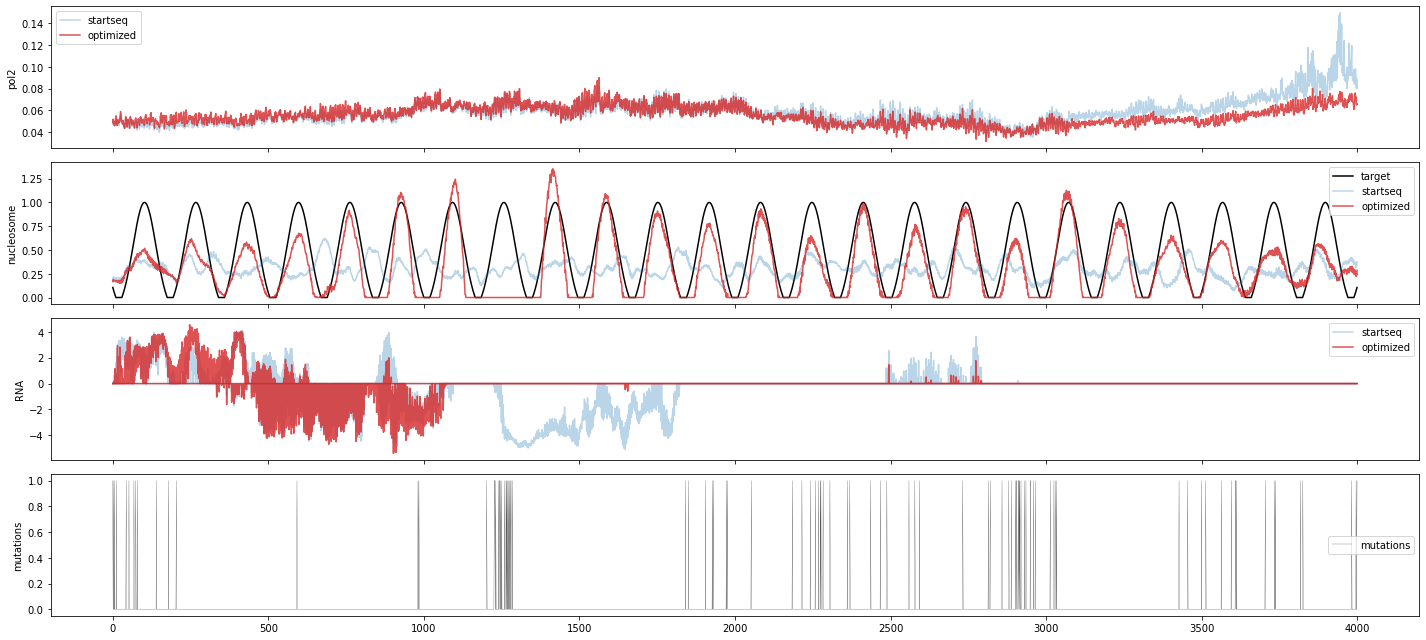

In [88]:
# single seq plot
seq_idx = 0
length = to_predict.shape[-1]
targ_row = 1
fig, axes = plt.subplots(
    4, 1, figsize=(20, 9), facecolor="w", layout="tight", sharex=True, sharey="row"
)
# targ_ax.plot(-target_rev, color='k')
axes[targ_row].plot(target, color="k", label="target")
if np.any(target_rev != target):
    axes[targ_row].plot(-target_rev, color="k", label="target_rev")
for i, (step, color, alpha, label) in enumerate(
    zip(steps, colors[::3], [0.3, 0.8], ["startseq", "optimized"])
):
    axes[0].plot(merge_pol[seq_idx, i, :], color=color, label=label, alpha=alpha)
    axes[1].plot(merge_nuc[seq_idx, i, :], color=color, label=label, alpha=alpha)
    axes[2].plot(
        indices_rna, preds_rna[seq_idx, i, :], color=color, label=label, alpha=alpha
    )
    axes[2].plot(
        indices_rna_rev, -preds_rna_rev[seq_idx, i, :], color=color, alpha=alpha
    )
    # break
# axes[3].bar(np.where(seqs[seq_idx, steps[0]] != seqs[seq_idx, steps[-1]])[0], height=1, width=1, color='k', label='mutations')
axes[3].plot(
    seqs[seq_idx, steps[0]] != seqs[seq_idx, steps[-1]],
    linewidth=0.2,
    color="k",
    label="mutations",
)
for ax, ylab in zip(axes, ["pol2", "nucleosome", "RNA", "mutations"]):
    ax.legend()
    ax.set_ylabel(ylab)
filename = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/profiles_start_end_with_mut.png"
)
fig.savefig(filename, bbox_inches="tight")

Text(170, 0.45049007107438166, '0.45')

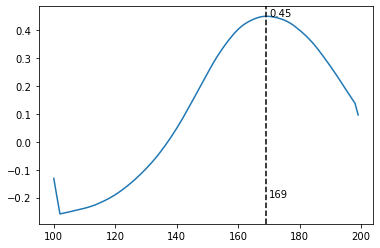

In [58]:
res = utils.sliding_correlation(
    merge_nuc[0, -1, :], merge_nuc[0, -1, :], offsets=np.arange(100, 200)
)
res = utils.smooth(res, 4)
amax = np.argmax(res)
100 + amax, res[amax]
plt.plot(np.arange(100, 200), res)
plt.axvline(x=100 + amax, color="k", linestyle="--")
plt.annotate(f"{100 + amax}", (100 + amax + 1, -0.2))
plt.annotate(f"{res[amax]:.2f}", (100 + amax + 1, res[amax]))